In [1]:
import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.notebook import trange, tqdm, tqdm_notebook
from joblib import Parallel, delayed
import re
import h5py
import tifffile as tiff
from natsort import natsort_keygen, natsorted

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()
data_processed = data_dir / 'processed'


In [5]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_meta_path = data_dir /'13cyc_3D'  / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_meta_path)

In [6]:
df_imgs.head()

,Condition,FOV,Z,Path
0,100nM,FW1,z1,y:\coskun-lab\Thomas\23_PLA_revision\data\13cy...
1,100nM,FW1,z2,y:\coskun-lab\Thomas\23_PLA_revision\data\13cy...
2,100nM,FW1,z3,y:\coskun-lab\Thomas\23_PLA_revision\data\13cy...
3,100nM,FW1,z4,y:\coskun-lab\Thomas\23_PLA_revision\data\13cy...
4,100nM,FW1,z5,y:\coskun-lab\Thomas\23_PLA_revision\data\13cy...


# Viz 3D PPI image

In [12]:
import networkx as nx

def read_pkl(path):
    with open(path, 'rb') as f:
        item = pickle.load(f)
    return item

plt.style.use('dark_background')

def plot_PPI_3D(network, node_colors):
    # Get position dict
    pos_dict = nx.get_node_attributes(network, 'pos')
    pos_T = {k: v[[1,0,2]] for k,v in pos_dict.items()}
    # Get position array
    pos = np.array(list(pos_T.values()))
    # Get node and edge location
    node_xyz = np.array([pos_T[v] for v in sorted(network)])
    edge_xyz = np.array([(pos_T[u], pos_T[v]) for u, v in network.edges()])

    # Create the 3D figure
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection="3d")

    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color='w', lw=1, alpha=0.5)
    ax.scatter(*node_xyz.T, s=70, c=node_colors)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    return fig, ax

In [8]:
from sklearn.preprocessing import OneHotEncoder
import matplotlib 
import scanpy
import palettable

# Get encoder 
PPI_save_path =  data_dir / '13cyc_3D' / 'PPI'

# Read PPi info 
dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)
df = pd.concat(dfs)

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
labels = enc.fit_transform(df['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)
df['Labels'] = labels.tolist()
print(enc.categories_)
PPIs_name = enc.categories_[0]

# Define colormap
colors  = palettable.tableau.Tableau_20.mpl_colors

colors_rgb = []
for color in colors:
    colors_rgb.append(np.array(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(PPIs_name, colors_rgb)}

[array(['AKT/Mtor', 'Bim/Tom20', 'Cyclin D1/CDK4', 'Cyclin E/CDK2',
       'EGFR/GRB2', 'FoxO1/AKT', 'Mcl-1/BAK', 'NF-Kb/p-P90rsk',
       'SIRT1/P53', 'Sox2/Oct4', 'TEAD1/YAP', 'TRAIL/DR5', 'p-ERK/c-MYC'],
      dtype=object)]


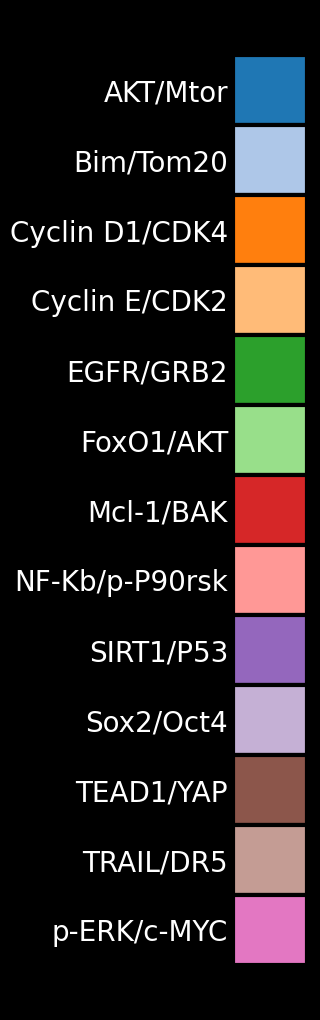

In [9]:
# legend
fig, ax = plt.subplots(figsize=(1,len(PPIs_name)))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=np.array(list(colors_rgb_dict.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )

_ = plt.yticks(range(len(colors_rgb_dict.values())), colors_rgb_dict.keys(), rotation=0, size=20)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)

In [10]:
import PLA

graph_save_path =  data_dir / '13cyc_3D' / 'graphs' / 'raw'
contour_save_path =  data_dir / '13cyc_3D' / 'contours'

cell_data = PLA.cell_data(contour_save_path, graph_save_path)


Loading graphs
Loading contours


In [11]:
import pickle 

# Check if graph connected
df_subset = cell_data.df.sample(100)
for i in range(len(df_subset)):
    # Info
    row = df_subset.iloc[i]
    key = '_'.join(row.iloc[:2])
    
    cell = row.iloc[2]
    
    # Get graph
    network = read_pkl(row.Path)
    
    if not nx.is_connected(network):
        print(row)
        
# Print existing node attributes in graph
node_attr = {k for attr_dict in network.nodes.data()._nodes.values() for k in attr_dict.keys()}
print(node_attr)

{'nuclei', 'labels', 'pos'}


In [16]:
fig_dir = (Path().cwd().parents[0] / 'figures').absolute()

fig_path = fig_dir / 'PPI' / '13PPI_3D' / 'Cell'
fig_path.mkdir(parents=True, exist_ok=True)    

In [17]:
df_subset = cell_data.df

for i in range(len(df_subset)):
# for i in range(10):
    # Info
    row = df_subset.iloc[i]
    key = '_'.join(row.iloc[:2])
    cell = row.iloc[2]
    
    # Get graph
    network = read_pkl(row.Path)
    network.remove_edges_from(list(nx.selfloop_edges(network)))
    
    nuclei = list(nx.get_node_attributes(network, 'nuclei').values())
    labels = list(nx.get_node_attributes(network, 'labels').values())
    labels = np.argmax(labels, axis=1)
    node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]

    # Plot
    fig, ax = plot_PPI_3D(network, node_colors)
    ax.elev = 30
    file_name = '_'.join([key, cell])
    fig.savefig(fig_path / f'{file_name}.png', dpi=800, bbox_inches='tight', pad_inches=0)
    plt.close()
